# The hidden secrets of the bitcoin price

Bitcoin is a digital currency created in 2009 by Satoshi Nakamoto, he describes it as a "peer-to-peer version of electronic cash" <cite> nakamoto2019bitcoin </cite>.
One big advantage of cryptocurrency over other market products, is that all the data is open, immutable and public, residing inside the blockchain.
The openness of the data has made the research behind blockchain really active, mostly on the price forecasting (<cite> jang2017empirical </cite>, <cite> mudassir2020time </cite>).
Many rush into the blockchain data, but I will show in this post that the bitcoin price itself is already really informative.

## tl;dr
1. Two important properties for a time-serie: stationnarity (distribution depends on the time) and seasonnality (recurrent patterns in the data).
2. Auto-correlation to check if a data is non-stationnary, derivative or data filtering/substraction to remove the non-stationnary component.
3. FFT and short FFT to analyse the seasonnality.

## 1 Fundamental properties of time series

There are two important properties : seasonality and stationarity.
Seasonnality represents how frequent the data change (for the bitcoin price we can express it in cycles per day), and also when does it starts.
A stationnary process means that the distribution (statistical properties) of the data does not changes over time, this kind of data is much more easy to model.
We will first focus on the analysis of the stationarity, and after the seasonality.

### 1.1 Stationnarity

One way to detect if a data is stationnay is to compute the autocorrelation of the data, if it degrades quickly it is stationnary.
There are many different types of non-stationnary data in the litterature, so I suggest you to read the [following post](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)
if you want to learn more on it.
Check also [this figure](https://otexts.com/fpp2/stationarity.html) and try to guess which time-serie is stationary!

### 1.2 Seasonnality

To analyse the seasonality of the bitcoin, we can make a [fourier analysis](https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/) to extract the most proeminent frequencies.
The magnitude of the fft (or the frequencies values) inform us how the given frequency component affect the price.
In the other hand, the phase of the fft is interresting to understand when does the dynamic of the price starts.
If the magnitude or phase has a random white noise trend, then there is no evidence of principal component.
Check this nice [blog post](https://machinelearningmastery.com/time-series-seasonality-with-python/) if you want to learn more on seasonnality.

## 2. Code

## 2.1 Loading the data

The hourly USD price for the bitcoin can be collected using [glassnode](https://studio.glassnode.com/pricing), with their advanced subscription.
Here we will use hourly data to get a more precise analysis.

In [1]:
### imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
# function to read the data
def read_data(filepath):
    price = []
    time = []
    
    with open(filepath) as f:
        lines = f.readlines()[1:]

    for data in lines:
        curr_time = float(data.split(",")[0])
        curr_price = -1
        if data.split(",")[1][:-1]:
            curr_price = float(data.split(",")[1][:-1])
        time += [curr_time]
        price += [curr_price]
        
    return np.array(price, dtype=np.float32), np.array(time, dtype=int)

In [3]:
# define paths
filepath = "data/market/price_usd_close_BTC_1h"
figure_dir = ""

# loading the hourly data, to avoid unimformative data, we skip the first year (8760 h)
price, time = read_data(filepath)
time_shifted = time - time[0]
price = price[8760:]
time_shifted = time_shifted[8760:]

The non-stationnary behaviour of the data is obvious when looking at the bitcoin price.
We can also see clearly the big rises of Dec 2017/2020 there.

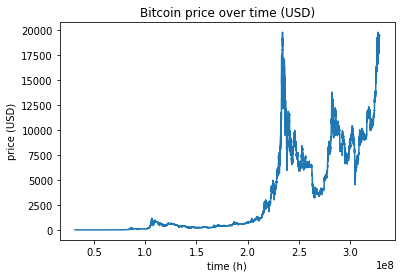

In [4]:
### plot
plt.figure()
plt.plot(time_shifted, price)
plt.title("Bitcoin price over time (USD)")
plt.ylabel("price (USD)")
plt.xlabel("time (h)")
if figure_dir:
    plt.savefig(os.path.join(figure_dir, "price.png"))
plt.show()
plt.close()

## 2.2 Stationnarity

One way to remove the non-stationnary component on the data is to compute its derivative.
An other way is to filter the data with a gaussian kernel, and substract it to the original price data.

In [5]:
# derivative
price_dt = price[1:] - price[:-1]

# filter
filter_width = 12
def gaussian_kernel_1d(filter_width):
    #99% of the values
    sigma = (filter_width)/2.33
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    kernel = [norm * np.exp((-1)*(x**2)/(2 * sigma**2)) for x in range(-filter_width, filter_width + 1)]
    return np.float32(kernel / np.sum(kernel))
f = tf.reshape(gaussian_kernel_1d(filter_width), [-1, 1, 1])
tf_price = tf.reshape(tf.constant(price, dtype=tf.float32), [1, -1, 1])
tf_price = tf.reshape(tf.nn.conv1d(tf_price, filters=f, stride=1, padding='VALID'), [-1])
# padding is necessary to keep same dim
tf_price = tf.concat([ tf.constant(tf_price[0].numpy(), shape=filter_width), tf_price ], axis=0)
filt_price = tf.concat([ tf_price,tf.constant(tf_price[-1].numpy(), shape=filter_width) ], axis=0).numpy()
price_centered = price - filt_price

We can compare the two methods, the resulting prices are now zero-centered.

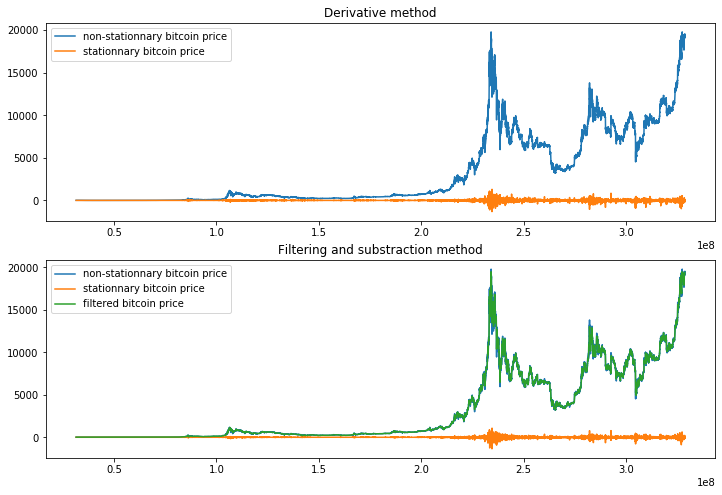

In [6]:
### plot
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(time_shifted, price, label="non-stationnary bitcoin price")
axes[0].plot(time_shifted[:-1], price_dt, label="stationnary bitcoin price")
axes[0].set_title('Derivative method')
axes[0].legend(loc="upper left")
axes[1].plot(time_shifted, price, label="non-stationnary bitcoin price")
axes[1].plot(time_shifted, price_centered, label="stationnary bitcoin price")
axes[1].plot(time_shifted, filt_price, label="filtered bitcoin price")
axes[1].set_title('Filtering and substraction method')
axes[1].legend(loc="upper left")
if figure_dir:
    plt.savefig(os.path.join(figure_dir, "price_stationnarity.png"))
plt.show()
plt.close()

We can also check the auto-correlation for the raw price data, and without the non-stationnary component.
This will inform us about how well the data is stationnary after the filtering.
We will compute the auto-correlations with different delays of up to 2 days every hours.

In [7]:
### auto-correlation function
def autocorr(input, delay):
    input = tf.constant(input, dtype=tf.float32)
    input_delayed = tf.roll(input, shift=delay, axis=0)

    x1 = tf.reshape(input, [1, -1, 1])
    x2 = tf.reshape(input_delayed, [-1, 1, 1])
    return tf.reshape(tf.nn.conv1d(x1, filters=x2, stride=1, padding='VALID'), [-1])

In [8]:
# autocorrelation of the price for different delays
delays = np.arange(0, 48)
# raw price data
autocorr_price = []
for hour in delays:
    autocorr_price += [autocorr(price, hour)]
# stationnary data
autocorr_centered_price = []
for hour in delays:
    autocorr_centered_price += [autocorr(price_centered, hour)]

looking at the plot, it is clear that the auto-correlation for the stationnary data degrades much faster than for the raw price data.
This means that we successfully removed the non-stationnary component for the price!

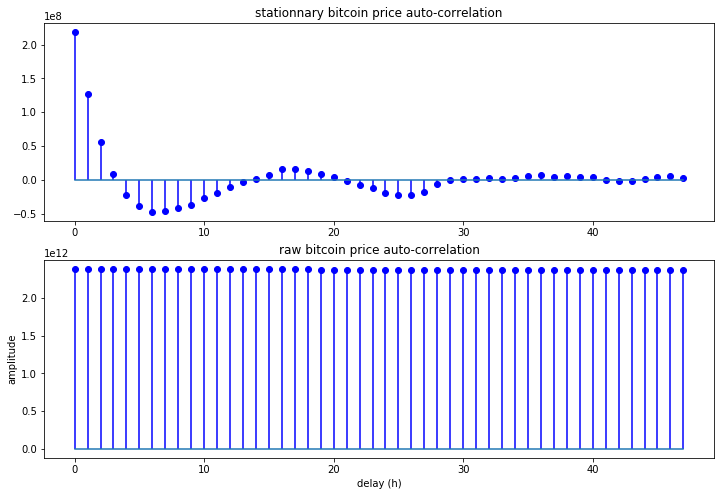

In [9]:
### plot
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].stem(delays, autocorr_centered_price, linefmt='b-', markerfmt='bo', basefmt='', use_line_collection=True)
axes[0].set_title('stationnary bitcoin price auto-correlation')
axes[1].stem(delays, autocorr_price, linefmt='b-', markerfmt='bo', basefmt='', use_line_collection=True)
axes[1].set_title('raw bitcoin price auto-correlation')
axes[1].set(xlabel='delay (h)', ylabel='amplitude')
if figure_dir:
    plt.savefig(os.path.join(figure_dir, "check_stationnarity.png"))
plt.show()
plt.close()

Finally, we can check how fast, for a given timestamp, the distribution of the raw price differ within its neighbors.
By comparing the histogram (i.e. computing the correlation) for each timestamp with its neighbors, one can get an overview of what would be the acceptable range for a prediction.
With the idea that if the distributions are close to each other, it is obviously easier to predict.

In [10]:
### histogram function
def data_distribution(inp):
    return np.histogram(inp, range=(0, 20000), bins=500, density=True)[0]

In [11]:
win_size = 2*24 #distribution of the data is calculated within 2 days (in hours)
slide = 5*24 #we slide up to -/+ 5 days
corr = []

# loop through al timestamps
timestamps_range = np.arange(slide + int(win_size/2), len(price) - slide - int(win_size/2), 72)
sliding_range = np.arange(-slide, slide + 1)
for i in timestamps_range:
    idx = i-int(win_size/2)
    # distribution of the price (over price from day -7.5 to day +7.5), the fixed distributioin
    fixed_price = price[idx:int(idx + win_size)]
    fixed_distrib = data_distribution(fixed_price)
    curr_corr = []
     # compare to each distribution at different timestamps (sliding from -30 to +30), the moving distribution 
    for offset in sliding_range:
        idx = offset + i - int(win_size/2)
        moving_price = price[idx:(idx + win_size)]
        moving_distrib = data_distribution(moving_price)
        curr_corr += [np.correlate(fixed_distrib, moving_distrib)]
    curr_corr = curr_corr / np.max(curr_corr)    
    corr += [curr_corr]    
    if i%7992 == 0:
        print("day {}/{}".format(i/24, len(price)/24))

output = np.array(corr)[:, :, 0]

day 333.0/3439.5


day 666.0/3439.5


day 999.0/3439.5


day 1332.0/3439.5


day 1665.0/3439.5


day 1998.0/3439.5


day 2331.0/3439.5


day 2664.0/3439.5


day 2997.0/3439.5


day 3330.0/3439.5


looking at this plot, we can say that ~~it looks like a sunset in black and white~~ an acceptable range for prediction is around +/-15 hours.

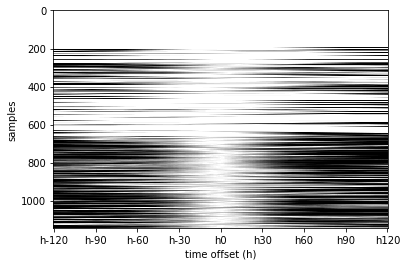

In [12]:
### plot
plt.imshow(output, cmap="gray")
plt.axis("tight")
idx_sliding_range = np.arange(0, len(sliding_range), 30)
plt.xticks([i for i in idx_sliding_range], ["h{}".format(sliding_range[i]) for i in idx_sliding_range])
plt.xlabel("time offset (h)")
plt.ylabel("samples")
if figure_dir:
    plt.imsave(os.path.join(figure_dir, "range_accuracy.png"), output, cmap="gray")
plt.show()
plt.close()

## 2.3 Seasonnality

Let's compute the fft now, and extract its magnitude and phase components.
Obviously, the ftt can be used after the non-stationnary component of the price data was removed.

In [13]:
# fft
price_fouried = tf.signal.fft(price_centered)
T = 1/24 # sampling interval in days
N = price_fouried.shape[0]
frequencies = np.linspace(0, 1 / T, N)

There is no clear evidence of a pattern there, although we see evidence for important frequency ranging from 1 to 1.9 cycles per day, with a little peak at 1.52.
This means that the bitcoin price can "generally" be explained by a sinusoid with a period of ~15.8 hours.

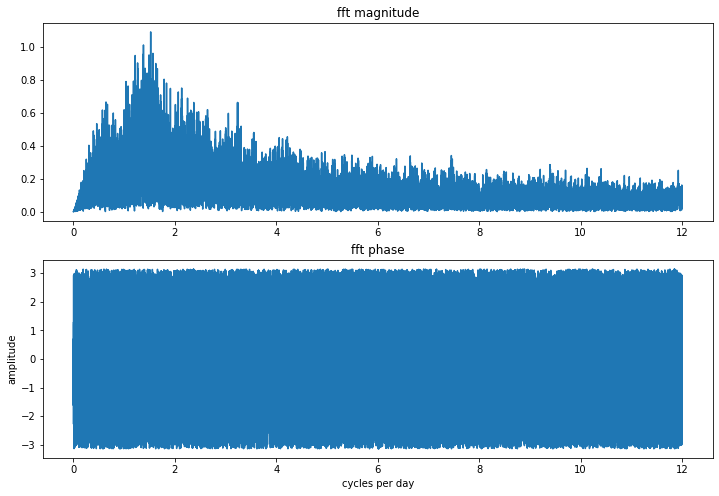

In [14]:
### plot
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(frequencies[:N // 2], tf.abs(price_fouried)[:N // 2] * 1 / N)
axes[0].set_title('fft magnitude')
axes[1].plot(frequencies[:N // 2], tf.math.angle(price_fouried)[:N // 2])
axes[1].set_title('fft phase')
axes[1].set(xlabel='cycles per day', ylabel='amplitude')
if figure_dir:
    plt.savefig(os.path.join(figure_dir, "fft.png"))
plt.show()
plt.close()

To finish on seasonality anaylisis, let's take a look at the spectrogram of the data (derived from a time-frequency analysis).
This will give us lot of informations on the statistical information at each time.
The spectrogram can be extracted using a short-fourier transform, which basically runs a fourier transform on a short window, sliding through all the data.
Here, we will have a window size of 48 samples (hours), with a step of 1 and 125 frequency components.

In [15]:
# tensorflow provide a fast implementation of fast fourier transform.
stft = tf.signal.stft(price_dt, frame_length=48, frame_step=1, fft_length=125, pad_end=True)
print(stft.shape)
spectrogram = tf.abs(stft).numpy()

(82547, 63)


Whenever there a big changes in the data (for example Dec. 2017), there is a much higher magnitude response.
Generally speaking, it seems that the fft looks like a white noise whenever the time.

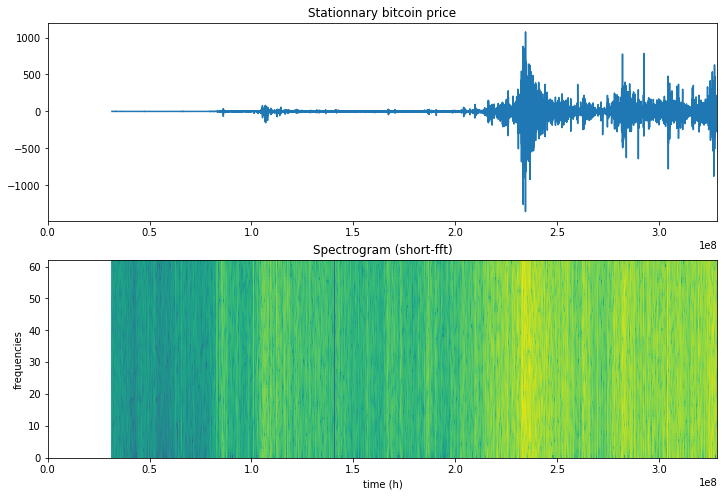

In [16]:
### plot
# inspired from https://www.tensorflow.org/tutorials/audio/simple_audio
# convert to log scale and transpose so that the time is represented in the x-axis (columns).
fig, axes = plt.subplots(2, figsize=(12, 8))
max_time = np.max(time_shifted)
axes[0].plot(time_shifted, price_centered)
axes[0].set_xlim([0, max_time])
axes[0].set_title('Stationnary bitcoin price')
log_spec = np.log(spectrogram.T)
axes[1].pcolormesh(time_shifted, np.arange(log_spec.shape[0]), log_spec)
axes[1].set_xlim([0, max_time])
axes[1].set_title('Spectrogram (short-fft)')
axes[1].set(xlabel='time (h)', ylabel='frequencies')
if figure_dir:
    plt.savefig(os.path.join(figure_dir, "spectrogram.png"))
plt.show()
plt.close()

## Conclusion

Stationnarity and seasonnality are two really important properties of a time-serie.
With different methods, it unlocked lot of understanding behind the bitcoin price like the difficulty in modeling it (especially the non-stationnary part) and what patterns exists in the data. 

## To go further

I really suggest you to read the book from Hyndman <cite> hyndman2018forecasting </cite>, it covers all best practices for time-series forecasting as well as coding examples.
The online version is available [here](https://otexts.com/fpp2/index.html).

## Acknowledgement

Credits goes to [Bitprobe](https://bitprobe.io/).

## Tags

Data-Science; Cryptocurrency; Statistics;